## Zadanie 2.
a) Zaimplementuj algorytm PBIL.

b) Sprawdź jego działanie na kilku prostych testowych problemach optymalizacji (OneMax, Deceptive OneMax, K-Deceptive OneMax). Eksperymenty obliczeniowe wykonaj dla różnych wielkości problemu i różnych ustawień algorytmu. Dokładnie przeanalizuj wyniki.

In [88]:
import numpy as np
import pandas as pd

from tqdm import trange, tqdm
import matplotlib.pyplot as plt

from itertools import product

In [65]:
def _default_eval_func(population):
    return np.array([np.count_nonzero(individual == 1) 
                     for individual in population])

In [112]:
class PBIL:
    
    def __init__(self, population_size, learning_rate, 
                 mutation_prob, disturbance_rate, allele_no, max_iter=1000, 
                 eval_func=_default_eval_func, with_tqdm=True):
        self.population_size = population_size
        self.learning_rate = learning_rate
        self.mutation_prob = mutation_prob
        self.disturbance_rate = disturbance_rate
        self.prob_vect = np.full(allele_no, 0.5)
        self.allele_no = allele_no
        self.max_iter = max_iter
        self.eval_func = eval_func
        self.with_tqdm = with_tqdm
      
    def fit(self):
        if self.eval_func is None:
            self.eval_func
            
        self.best_evals = np.zeros(self.max_iter)
        self.mean_evals = np.zeros(self.max_iter)
        self.worst_evals = np.zeros(self.max_iter)
        
        population = self._random_population()
        evals = self.eval_func(population)
        
        if self.with_tqdm:
            range_ = trange(self.max_iter, desc='epoch', position=0, leave=True)
        else:
            range_ = range(self.max_iter)
            
        for epoch in range_:
            best = population[evals.argmax()]

            self.best_evals[epoch] = evals.max()
            self.mean_evals[epoch] = evals.mean()
            self.worst_evals[epoch] = evals.min()
            
            # learn
            self.prob_vect = self.prob_vect * (1 - self.learning_rate) + \
                            best * self.learning_rate
            #mutate
            for idx in (np.random.rand(self.allele_no) < self.mutation_prob).nonzero():
                self.prob_vect[idx] = self.prob_vect[idx] * (1 - self.disturbance_rate) + \
                                        self._binary_random(0.5) * self.disturbance_rate
            
            population = self._random_population()
            evals = self.eval_func(population)
            
    
    def plot_evals(self, with_params=False):
        plt.figure()
        if with_params:
            plt.title(f'Eval changes for learning_rate: {self.learning_rate}, \
mutation_prob: {self.mutation_prob}, disturbance_rate: {self.disturbance_rate}')
        else:
            plt.title('Eval changes')
        
        plt.plot(range(self.max_iter), self.best_evals, c='g', linewidth=0.4)
        plt.plot(range(self.max_iter), self.mean_evals, c='b', linewidth=0.4)
        plt.plot(range(self.max_iter), self.worst_evals, c='r', linewidth=0.4)
        plt.show()
    
    def _binary_random(self, p):
        if np.random.rand() < p:
            return 1
        else:
            return 0
    
    def _random_individual(self, p):
        return np.array([self._binary_random(pk) for pk in p])
    
    def _random_population(self):
        return np.array([self._random_individual(self.prob_vect) 
                         for _ in range(self.population_size)])

In [67]:
allele_no = 100

def deceptive_one_max_eval_func(population):
    return np.array([len(individual)+1 if individual.sum() == 0 
                     else np.count_nonzero(individual == 1) for individual in population])

100%|██████████| 64/64 [11:35<00:00, 10.87s/it]


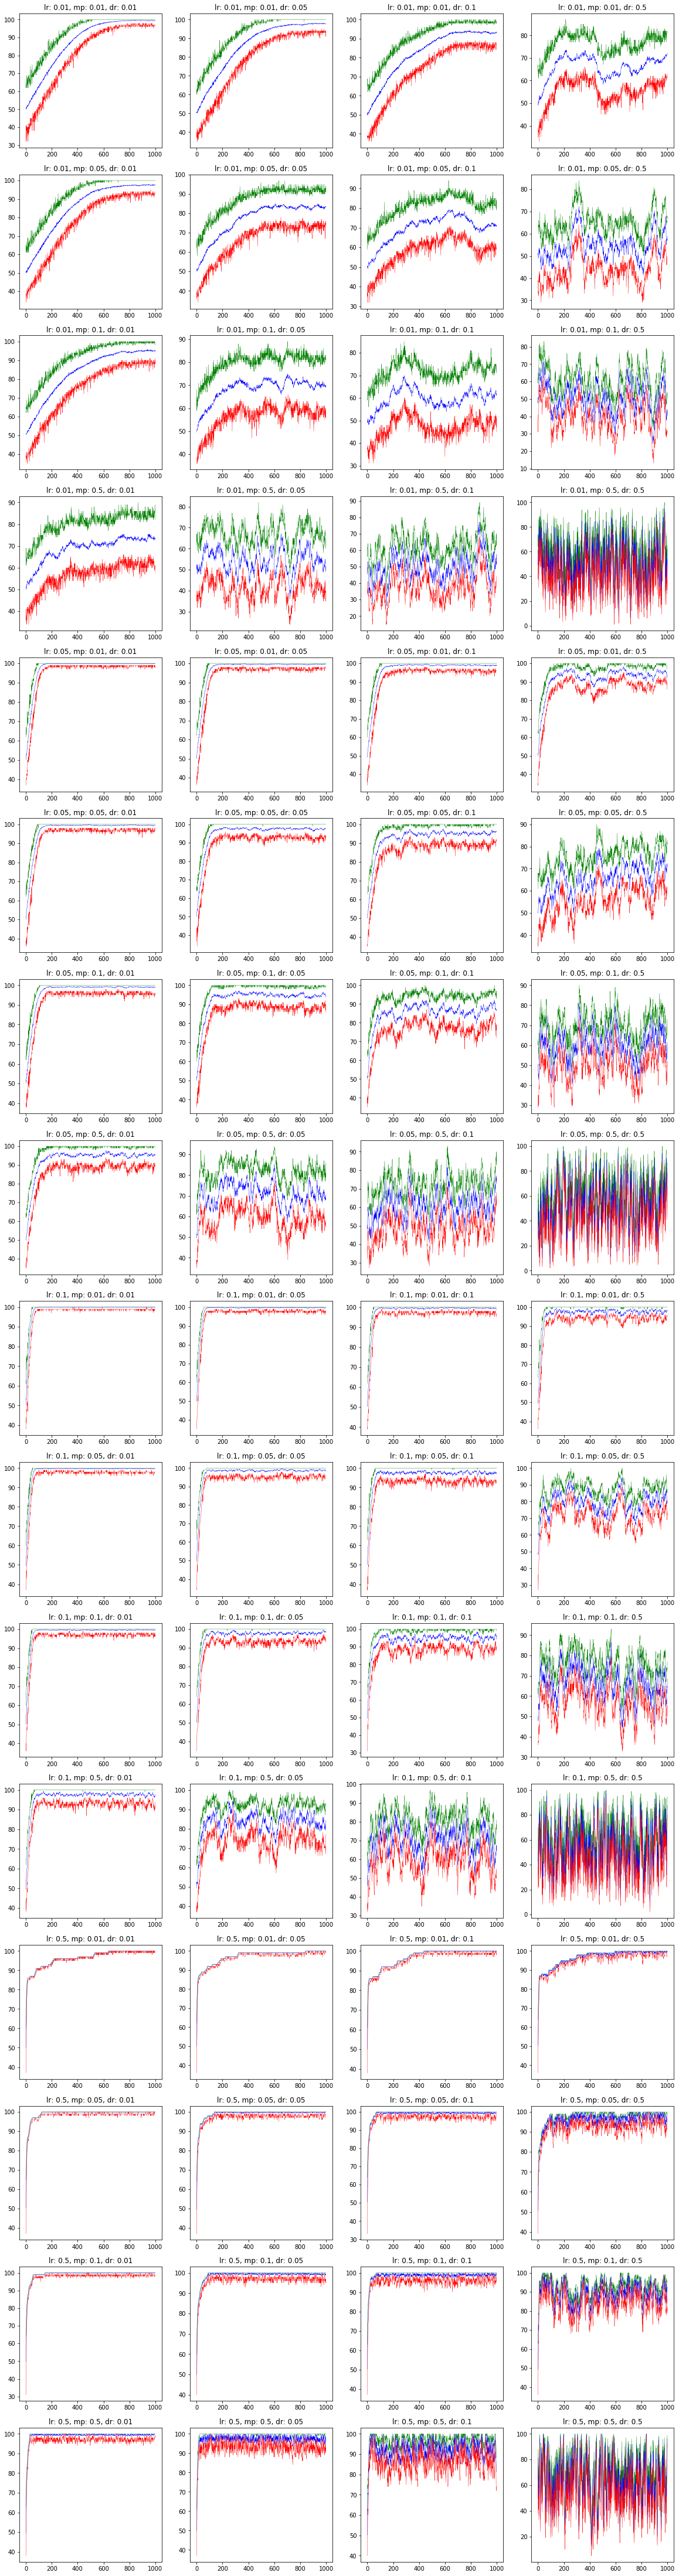

In [124]:
LR = MP = DR = [0.01, 0.05, 0.1, 0.5]
# LR = MP = DR = [0.01, 0.05]

fig, ax = plt.subplots(len(LR)**2, len(LR), figsize=(20, 80))

for i, (lr, mp, dr) in tqdm(enumerate(product(LR, MP, DR)), position=0, leave=True,
                           total=len(LR)**3):
    pbil_om = PBIL(population_size=125, learning_rate=lr, 
            mutation_prob=mp, disturbance_rate=dr, allele_no=allele_no, with_tqdm=False)
    pbil_om.fit()
    cur_ax = ax[i//len(LR)][i%len(LR)]
    cur_ax.set_title(f'lr: {lr}, mp: {mp}, dr: {dr}')
    
    cur_ax.plot(range(pbil_om.max_iter), pbil_om.best_evals, c='g', linewidth=0.4)
    cur_ax.plot(range(pbil_om.max_iter), pbil_om.mean_evals, c='b', linewidth=0.4)
    cur_ax.plot(range(pbil_om.max_iter), pbil_om.worst_evals, c='r', linewidth=0.4)

epoch: 100%|██████████| 1000/1000 [00:05<00:00, 168.62it/s]


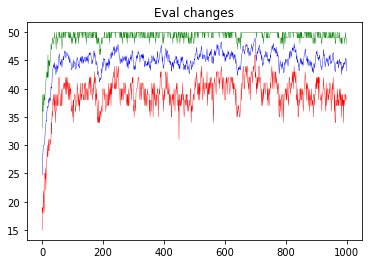

50.0

In [87]:
pbil_dom = PBIL(population_size=125, learning_rate=0.1, mutation_prob=0.2, 
                disturbance_rate=0.1, allele_no=50, 
                eval_func=deceptive_one_max_eval_func)
pbil_dom.fit()
pbil_dom.plot_evals()
pbil_dom.best_evals.max()